In [ ]:
!pip3 install opencv-contrib-python
!pip install onnx
!pip install timm
!pip install mahotas

In [ ]:
# import the necessary packages
import numpy as np
import time
from collections import namedtuple
from google.colab.patches import cv2_imshow
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import imutils
from imutils import contours
import cv2
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
width_pixel_per_cm = 3
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

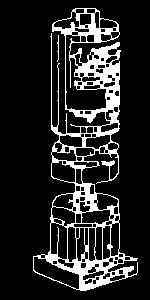

In [ ]:
# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread("/content/Product.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 30, 50)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None
cv2_imshow(edged)

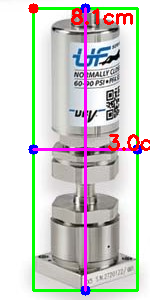

In [ ]:
# loop over the contours individually
for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
        continue
    # compute the rotated bounding box of the contour
    orig = image.copy()
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    # loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
        # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)
        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
        # draw the midpoints on the image
        cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
        # draw lines between the midpoints
        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
            (255, 0, 255), 2)
        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
            (255, 0, 255), 2)
        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
        # if the pixels per metric has not been initialized, then
        # compute it as the ratio of pixels to supplied metric
        # (in this case, inches)
        if pixelsPerMetric is None:
            pixelsPerMetric = dB / width_pixel_per_cm
        # compute the size of the object
            dimA = dA / pixelsPerMetric
            dimB = dB / pixelsPerMetric
            # draw the object sizes on the image
            cv2.putText(orig, "{:.1f}cm".format(dimA),
                (int(tltrX-15), int(tltrY+15)), cv2.FONT_HERSHEY_SIMPLEX,
                0.65, (0, 0, 255), 2)
            cv2.putText(orig, "{:.1f}cm".format(dimB),
                (int(trbrX-30), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
                0.65, (0, 0, 255), 2)
            # show the output image
            cv2_imshow(orig)
            cv2.waitKey(0)

In [ ]:
# define the list of boundaries
boundaries = [
	([17, 15, 100], [50, 56, 200]),
	([86, 31, 4], [220, 88, 50]),
	([25, 146, 190], [62, 174, 250]),
	([103, 86, 65], [145, 133, 128])
]

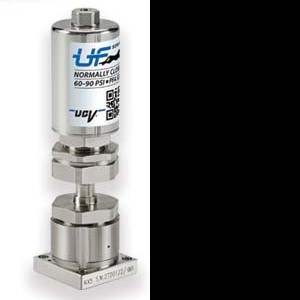

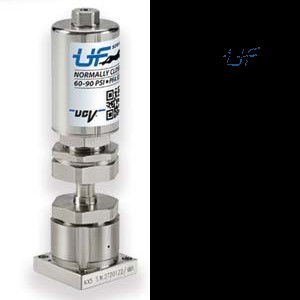

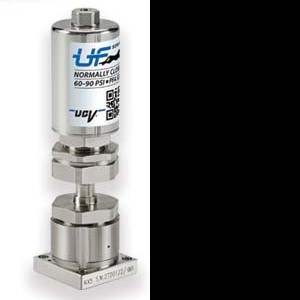

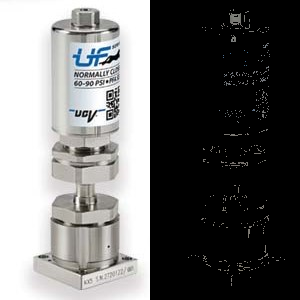

In [ ]:
# loop over the boundaries
for (lower, upper) in boundaries:
	# create NumPy arrays from the boundaries
	lower = np.array(lower, dtype = "uint8")
	upper = np.array(upper, dtype = "uint8")
	# find the colors within the specified boundaries and apply
	# the mask
	mask = cv2.inRange(image, lower, upper)
	output = cv2.bitwise_and(image, image, mask = mask)
	# show the images
	cv2_imshow(np.hstack([image, output]))
	cv2.waitKey(0)

In [ ]:
import onnx
onnx_model = onnx.load('/content/drive/Shareddrives/123/model-f46da743.onnx')

# Check the model
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid!')

The model is valid!


In [ ]:
# Load a MiDas model for depth estimation
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

# Load transforms to resize and normalize the image
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
image = cv2.imread("/content/Product.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

 # Apply input transforms
input_batch = transform(img).to(device)

# Prediction and resize to original resolution
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()
depth_map = cv2.normalize(depth_map, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)


img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

depth_map = (depth_map*255).astype(np.uint8)
depth_map = cv2.applyColorMap(depth_map , cv2.COLORMAP_MAGMA)



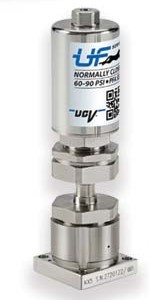

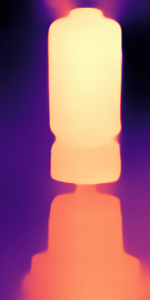

In [ ]:
cv2_imshow(img)
cv2_imshow(depth_map)

In [ ]:
# import the necessary packages
from scipy.spatial import distance as dist
import numpy as np
import mahotas
import cv2
import imutils

def describe_shapes(image):
    # initialize the list of shape features
    shapeFeatures = []

    # convert the image to grayscale, blur it, and threshold it
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (13, 13), 0)
    thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)[1]

    # perform a series of dilations and erosions to close holes
    # in the shapes
    thresh = cv2.dilate(thresh, None, iterations=4)
    thresh = cv2.erode(thresh, None, iterations=2)

    # detect contours in the edge map
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    for c in cnts:
        # create an empty mask for the contour and draw it
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)

        # extract the bounding box ROI from the mask
        (x, y, w, h) = cv2.boundingRect(c)
        roi = mask[y:y + h, x:x + w]

        # compute Zernike Moments for the ROI and update the list
        # of shape features
        features = mahotas.features.zernike_moments(roi, cv2.minEnclosingCircle(c)[1], degree=8)
        shapeFeatures.append(features)

    # return a tuple of the contours and shapes
    return (cnts, shapeFeatures)

# load the reference image containing the object we want to detect,
# then describe the game region
refImage = cv2.imread("pokemon_red.png")
(_, gameFeatures) = describe_shapes(refImage)

# load the shapes image, then describe each of the images in the image
shapesImage = cv2.imread("shapes.png")
(cnts, shapeFeatures) = describe_shapes(shapesImage)

# compute the Euclidean distances between the video game features
# and all other shapes in the second image, then find index of the
# smallest distance
D = dist.cdist(gameFeatures, shapeFeatures)
i = np.argmin(D)

# loop over the contours in the shapes image
for (j, c) in enumerate(cnts):
    # if the index of the current contour does not equal the index
    # contour of the contour with the smallest distance, then draw
    # it on the output image
    if i != j:
        box = cv2.minAreaRect(c)
        box = np.int0(cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box))
        cv2.drawContours(shapesImage, [box], -1, (0, 0, 255), 2)

# draw the bounding box around the detected shape
box = cv2.minAreaRect(cnts[i])
box = np.int0(cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box))
cv2.drawContours(shapesImage, [box], -1, (0, 255, 0), 2)
(x, y, w, h) = cv2.boundingRect(cnts[i])
cv2.putText(shapesImage, "FOUND!", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9,
    (0, 255, 0), 3)

# show the output images
cv2_imshow(refImage)
cv2_imshow(shapesImage)
cv2.waitKey(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars


1.0170328617095947
<class 'list'>


In [ ]:
def improved_zernike(image):
    # convert the image to grayscale, blur it, and threshold it
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    se=cv2.getStructuringElement(cv2.MORPH_RECT , (8,8))
    bg=cv2.morphologyEx(blurred, cv2.MORPH_DILATE, se)
    thresh = cv2.adaptiveThreshold(bg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                                cv2.THRESH_BINARY, 7, -2)
    cv2_imshow(thresh)
    img_added = cv2.Canny(thresh, 200, 250)
    cv2_imshow(img_added)
    """kernel_x = np.array([[0, 0, 0], [1, 0, -1], [0, 0, 0]])
    kernel_y = np.array([[0, 1, 0], [0, 0, 0], [0, -1, 0]])
    kernel_45 = np.array([[0, 0, 1], [0, 0, 0], [-1, 0, 0]])
    kernel_135 = np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]])

    img_robert_x = cv2.filter2D(thresh, -1, kernel_x)**2
    img_robert_y = cv2.filter2D(thresh, -1, kernel_y)**2
    img_robert_45 = cv2.filter2D(thresh, -1, kernel_45)**2
    img_robert_135 = cv2.filter2D(thresh, -1, kernel_135)**2

    img_added = img_robert_x + img_robert_y + img_robert_45 + img_robert_135
    img_added = img_added**(1/2)"""
    # perform a series of dilations and erosions to close holes
    # in the shapes
    img_added = cv2.dilate(img_added, None, iterations=2)
    img_added = cv2.erode(img_added, None, iterations=2)

    cv2_imshow(img_added)
    # detect contours in the edge map
    cnts = cv2.findContours(img_added.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts)

In [ ]:
improved_zernike(cv2.imread("Gear.png"))

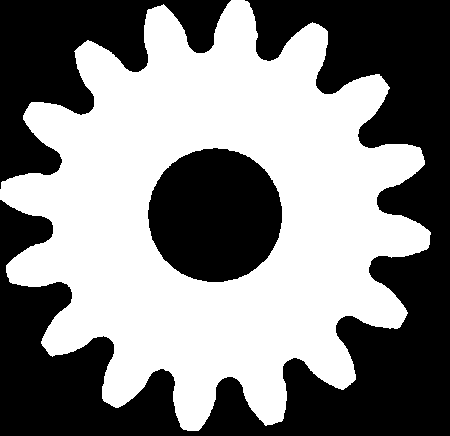

In [ ]:
image = cv2.imread("Gear.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 200, 255,
	cv2.THRESH_BINARY_INV)[1]
cv2_imshow(thresh)

[INFO] original, num_pts=1059


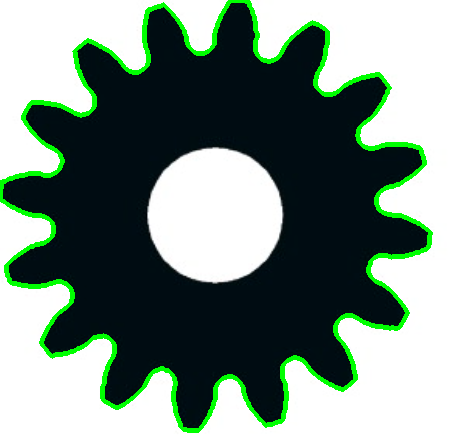

-1

In [ ]:
# find the largest contour in the threshold image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
# draw the shape of the contour on the output image, compute the
# bounding box, and display the number of points in the contour
output = image.copy()
cv2.drawContours(output, [c], -1, (0, 255, 0), 3)
(x, y, w, h) = cv2.boundingRect(c)
text = "original, num_pts={}".format(len(c))
cv2.putText(output, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX,
	0.9, (0, 255, 0), 2)
# show the original contour image
print("[INFO] {}".format(text))
cv2_imshow(output)
cv2.waitKey(0)

In [ ]:

for eps in np.linspace(0.001, 0.05, 10):
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, eps * peri, True)
	# draw the approximated contour on the image
	output = image.copy()
	cv2.drawContours(output, [approx], -1, (0, 255, 0), 3)
	text = "eps={:.4f}, num_pts={}".format(eps, len(approx))
	cv2.putText(output, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX,
		0.9, (0, 255, 0), 2)
	# show the approximated contour image
	print("[INFO] {}".format(text))
	cv2_imshow(output)
	cv2.waitKey(0)

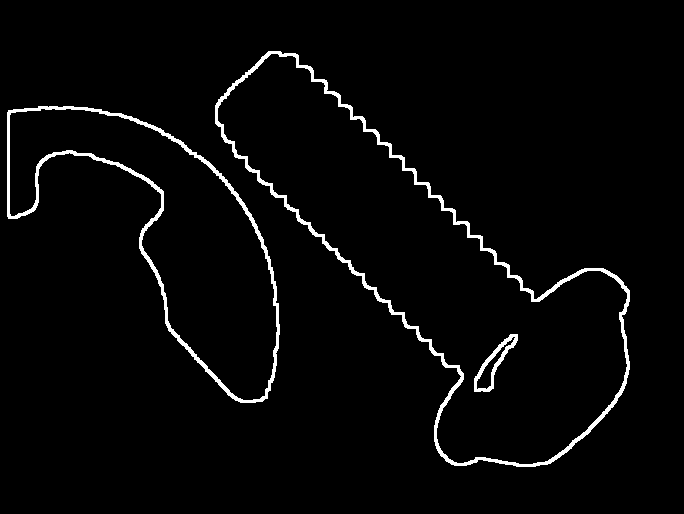

In [ ]:
image = cv2.imread("Nuts.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh, bw_img = cv2.threshold(gray, 200, 250,
	cv2.THRESH_BINARY_INV)

se=cv2.getStructuringElement(cv2.MORPH_RECT , (8,8))
bw_img=cv2.morphologyEx(bw_img, cv2.MORPH_DILATE, se)
bw_img = cv2.adaptiveThreshold(bw_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                            cv2.THRESH_BINARY, 7, -2)

cv2_imshow(bw_img)


In [ ]:
# all external modules used

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as pltick
from matplotlib.lines import Line2D # for getting the markers
from mpl_toolkits.mplot3d import Axes3D
#import scipy.interpolate as interpol
import scipy.optimize as opt
import scipy.signal as scig
import os
import cv2
import glob
#import mahotas
import xml.etree.ElementTree as et
import time
from tqdm import tqdm
import imageio # for animate
import sklearn as sk
import sklearn.mixture as mixture
#import plotly.express as px
#import plotly.graph_objects as go
import pandas as pd
from ipywidgets import widgets
import warnings
from datetime import datetime as datt

In [ ]:
############# CONSTANTS AND PARAMETERS #################################
SMALL = np.finfo(float).eps
rho_air = 1.2 # [kg/m3]
ni = 14.88*10**-6 # [m2/s] kinematic viscosity air
kappa = 0.4 # von Karman constant for atmospheric flows

############# PLOTTING CUSTOMIZATIONS ##################################
plt.rcParams["figure.figsize"] = np.array(plt.rcParams["figure.figsize"])*1
fsize = min(plt.rcParams['figure.figsize'])
#plt.rcParams["image.cmap"] = 'Spectral'
plt.rcParams["image.cmap"] = 'gray' # for images
plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.dpi"] = 200 # 100
markerlist = [ k for k in Line2D.markers.keys() ]
lineslist = [ k for k in Line2D.lineStyles.keys() ]
plt.rcParams['lines.markersize'] = 10
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.fancybox"] = False
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
ploting = True # disable if you don't want to see plots


############# TIER 1 ###################################################
def zero_to_small(A):
	"""
	take array A and values whose abs is smalleer than SMALL
	are converted to SMALL
	"""
	A[(A<SMALL) & (A>=0)] = SMALL
	A[(A>-SMALL) & (A<0)] = -SMALL
	return A

def poly_2d(x,y,K):
	return (K[0]+K[1]*x+K[2]*y + K[3]*x**2+K[4]*x*y+K[5]*y**2 +
		K[6]*x**3+K[7]*x**2*y+K[8]*x*y**2+K[9]*y**3)

def fname_dir(fname):
	"""
	returns the directory in which fname is located
	"""
	return os.path.abspath(os.path.join(fname,os.pardir))

def df_add(df,index,column,value):
	"""
	Add a new value at column and index. If either column or index
	do not exist they are created.
	Works for pandas dataframes.
	"""
	try:
		df[column]
	except:
		df[column]=np.nan
	try:
		df.loc[index]
	except:
		df.loc[index]=np.nan
	df.loc[index,column]=value
	return df

def gaussian(x,mu,sigma,A):
	return A/(sigma*np.sqrt(2*np.pi))*np.exp(
		-(x-mu)**2/(2*sigma**2))

def read_external_data(fname,sep='	',coma=False,bn=False,header=0):
	"""
	read a data file located in fname structured in lines and columns
	where each column is separated by sep. If the data uses comas
	instead of dots put replace=True to sort compatibility. In case \n
	shows up at the end of each line but bn=True. Header is
	the number of lines to be skipped at the start of the file.
	returns a matrix
	"""
	f = open(fname,"r")
	Lines = f.readlines()[header:]
	N = len(Lines)
	nVal = len(Lines[N-1].split(sep)) # using last line as reference for number of cloumns
	A = np.zeros((N,nVal))
	for line in range(N):
		if coma:
			Lines[line] = Lines[line].replace(',' , '.')
		if bn:
			Lines[line] = Lines[line].replace('\n' , '')
		A[line] = np.array(Lines[line].split(sep))
	f.close()
	return A.transpose()

def detect_circles(img,resolution=1,delta=10,canny=30,akku=15,rmin=10,rmax=-1):
	"""
	circles: x,y vecotor
	resolution: when multiplied by image size
	delta: min space between circles in px
	canny: threshold for canny edge. The higher the stricter.
	akku: threshold for hough circles accumulator. The higher the stricter.
	rmin: minimum radius of circles
	"""
	circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,resolution,delta,
              param1=canny,param2=akku,minRadius=rmin,maxRadius=rmax)[0,:,:-1]
	return circles

def nan_interp(A):
	"""
	Interpolate nans in a matrix
	"""
	ni,nj = np.shape(A)
	# extend edges of A by one
	A = np.concatenate((np.array([A[:,0]]).transpose(),A,np.array([A[:,-1]]).transpose()),axis=1)
	A = np.concatenate((np.array([A[0,:]]),A,np.array([A[-1,:]])),axis=0)

	#nit = 0
	#while np.sum(np.isnan(A)) != 0:
	#nit+=1
	nanp = np.isnan(A)
	for i in range(1,ni+1):
		for j in range(1,nj+1):
			if nanp[i,j]:
				#	# edges
				#	if (i==0) & (j!=0)& (j!=nj-1):
				#		b = np.array([A[i+1,j],A[i,j-1],A[i,j+1]])
				#	if (i==ni-1) & (j!=0)& (j!=nj-1):
				#		b = np.array([A[i-1,j],A[i,j-1],A[i,j+1]])
				#	if (j==0) & (i!=0)& (i!=ni-1):
				#		b = np.array([A[i-1,j],A[i+1,j],A[i,j+1]])
				#	if (j==nj-1) & (i!=0)& (i!=ni-1):
				#		b = np.array([A[i-1,j],A[i+1,j],A[i,j-1]])
				#	# corners
				#	if (i==0) & (j==0):
				#		b = np.array([A[i+1,j],A[i,j+1]])
				#	if (i==ni-1) & (j==0):
				#		b = np.array([A[i-1,j],A[i,j+1]])
				#	if (i==0) & (j==nj-1):
				#		b = np.array([A[i+1,j],A[i,j-1]])
				#	if (i==ni-1) & (j==nj-1):
				#		b = np.array([A[i-1,j],A[i,j-1]])
				#	# core
				#	else:
				b = np.array([A[i-1,j],A[i,j-1],A[i+1,j],A[i,j+1]])
				snan = np.sum(np.isnan(b))
				sb = np.nansum(b)
				A[i,j] = sb/(len(b)-snan)
				#print(i,j)
	# only the core matters
	A = A[1:ni+1,1:nj+1]
	return A

def new_directory(name):
	if not os.path.isdir(name):
		os.mkdir(name)
	return name

def read_image(fname):
	"""
	Return the loaded image as is (with alpha channel)
	As a numpy array
	"""
	img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
	return img

def dir_ftype(directory,extension):
	"""
	find all files with given extension in directory
	order them alphabetically in a list and return them
	"""
	extension = extension.replace(".","") # make sure theres no "."
	fnames = directory+os.sep+"*"+"."+extension
	fnames = glob.glob(fnames)
	fnames = np.sort(fnames) # order files from 0 to last
	return fnames

def dir_fname(directory,nametype):
	"""
	find all files with given extension and string in directory
	order them alphabetically in a list and return them
	"""
	fnames = directory+os.sep+nametype
	fnames = glob.glob(fnames)
	fnames = np.sort(fnames) # order files from 0 to last
	return fnames

def crop_image(img,roi):
	"""
	roi: region of interest, numpy slice, 4 elements,
	[y_min:y_max,x_min:x_max]
	"""
	img = img[roi]
	return img

def canny_edge(img,threshold=15,hysteresis=5):
	img = cv2.Canny(img, threshold-hysteresis,threshold+hysteresis)
	return img

def blur_image(img,Ks,strength=1):
	"""
	Gaussian blur. Currently using the cv2 package.
	Ks is the kernel size and strength is the sigma
	"""
	Ks = int(Ks)
	if Ks%2 != 1:
		print("blur_image: Ks must be odd! Continuing with Ks = Ks-1")
		Ks = Ks-1
	img = cv2.GaussianBlur(img,(Ks,Ks),strength)#sigmaX=
	return img

def blurd_image(img,order=5,direction='horizontal',strength=0.25,speed='slow'):
	"""
	blur in a given direction with a
	slow: low pass butterworth filter
	fast: directional averaging convolution
	"""
	ny,nx = np.shape(img)
	if speed == 'slow':
		b, a = scig.butter(order, strength)
		if direction == 'horizontal':
			for i in range(ny):
				img[i,:] = scig.filtfilt(b, a, img[i,:])
		elif direction == 'vertical':
			for i in range(nx):
				img[:,i] = scig.filtfilt(b, a, img[:,i])
		return img
	elif speed=='fast':
		K = np.ones((int(strength),1))
		K = K/np.sum(K)
		if direction=='vertical':
			img=scig.convolve2d(img,K,mode='same')
		elif direction=='horizontal':
			img=scig.convolve2d(img,K.transpose(),mode='same')
		return img



def zernike_Vnm(rho,theta,n,m):
	"""
	from [2] a function necessary for the calculation of any Anm
	"""
	Rnm = 0
	fact = lambda x: np.math.factorial(x)
	am = abs(m)
	for s in range(0,(n-am)/2):
		Rnm+= (-1)**s*fact(n-s)*rho**(n-2*s)/(
			fact(s)*fact((n+am)/2-s)*fact((n-am)/2-s))
	Vnm = Rnm*np.exp(1j*m*theta)


def ddx(a):
	"""
	The first derivative of a vector assuming a constant spacing of
	1 unit between poitns. Avoid edge effects
	"""
	# avoid corner effects
	thick = 2
	a = np.concatenate((a[(thick-1)::-1],a,a[:-(thick+1):-1]))
	mode="same"
	mode = "valid"

	K = np.array([-0.5,0,0.5])
	da = scig.convolve(a,K,mode=mode)
	return da

def ghosal_edge(img,Ks,thr=1,thrmax=0.995,lmin = 0.5,phimin=1.4,thresholding=True, debug=False):
	"""
	implementation of the subpixel edge detection method of [2]. The
	pixels are projected into a new orthogonal domain where a parameter
	k defines the intesity of the edge. By filtering out edges of small
	k the relevant ones remain. The extracted parameters are enough to
	define a straight edge.
	img: the image to be treated.
	Ks: kernel size
	thr: threshold paramter limiting the minimum of k
	thrmax: threshold limiting the maximum of k. This is usefull to
		remove reflections which have excessively sharp edges
	lmin: is the minimum distance between the pixel center and the
		detected edge. This avoids that big kernels do errors, when
		close to multiple edges. It also avoids values of l which are
		nonesense, since they only make sense for real edges.
	phimin: allows the user to define a minimum angle in redians
		measured between the y-axis and the edge.
	"""
	totaltime = time.time()
	kerneltime = time.time()
	# Ks must be odd
	if Ks%2 != 1:
		print("Ks must be odd! Continuing with Ks = Ks-1")
		Ks = Ks-1
	# define the rectangular kernels
	#Vc00 = np.zeros((Ks,Ks),dtype=complex)
	Vc11 = np.zeros((Ks,Ks),dtype=complex)
	Vc20 = np.zeros((Ks,Ks),dtype=complex)
	ofs = 1 *(1-1/Ks) # offset for centering kernel around 0,0
	for i in range(Ks):
		for j in range(Ks):
			Kx = 2*j/Ks-ofs # limits of integration between -1 and 1
			Ky = 2*i/Ks-ofs
			if Kx**2+Ky**2 <= 1: # only a circle
				#Vc00[i,j] = 1 # the conjugate of V00
				Vc11[i,j] = Kx-Ky*1j # ...
				Vc20[i,j] = 2*Kx**2+2*Ky**2-1
	kerneltime = time.time() - kerneltime

	# Kernel Plots
	#	VCplot = Vc00
	#	plt.pcolormesh(np.real(VCplot))
	#	plt.title("real w K Vc00")
	#	plt.colorbar()
	#	plt.show()
	#	plt.pcolormesh(np.imag(VCplot))
	#	plt.title("imag w K Vc00")
	#	plt.colorbar()
	#	plt.show()
	#	VCplot = Vc11
	#	plt.pcolormesh(np.real(VCplot))
	#	plt.title("real w K Vc11")
	#	plt.colorbar()
	#	plt.show()
	#	plt.pcolormesh(np.imag(VCplot))
	#	plt.title("imag w K Vc11")
	#	plt.colorbar()
	#	plt.show()
	#	VCplot = Vc20
	#	plt.pcolormesh(np.real(VCplot))
	#	plt.title("real w K Vc20")
	#	plt.colorbar()
	#	plt.show()
	#	plt.pcolormesh(np.imag(VCplot))
	#	plt.title("imag w K Vc20")
	#	plt.colorbar()
	#	plt.show()

	# do the convolution with the images to get the zernike moments
	Anorm = lambda n : (n+1)/np.pi	# a normalization value
	convolvetime = time.time()
	#A00 = scig.convolve2d(img,Vc00,mode='same')
	#	A11 = Anorm(1)*scig.convolve2d(img,Vc11,mode='same')
	#	A20 = Anorm(2)*scig.convolve2d(img,Vc20,mode='same')
	A11 = Anorm(1)*scig.oaconvolve(img,Vc11,mode='same')
	A20 = Anorm(2)*scig.oaconvolve(img,Vc20,mode='same')
	convolvetime = time.time() - convolvetime
	# Plot Zernike moments
	#	VCplot = A00
	#	plt.pcolormesh(np.real(VCplot))
	#	plt.title("real A00")
	#	plt.colorbar()
	#	plt.show()
	#	plt.pcolormesh(np.imag(VCplot))
	#	plt.title("imag A00")
	#	plt.colorbar()
	#	plt.show()
	#	VCplot = A11
	#	plt.pcolormesh(np.real(VCplot))
	#	plt.title("real A11")
	#	plt.colorbar()
	#	plt.show()
	#	plt.pcolormesh(np.imag(VCplot))
	#	plt.title("imag A11")
	#	plt.colorbar()
	#	plt.show()
	#	VCplot = A20
	#	plt.pcolormesh(np.real(VCplot))
	#	plt.title("real A20")
	#	plt.colorbar()
	#	plt.show()
	#	plt.pcolormesh(np.imag(VCplot))
	#	plt.title("imag A20")
	#	plt.colorbar()
	#	plt.show()

	paramstime = time.time()
	# calculate the edge paramters
	#	tanphi = np.imag(A11)/np.real(A11)
	#	phi = np.arctan(tanphi)
	#	cosphi = np.cos(phi)
	#	sinphi = cosphi*tanphi
	#	Al11 = np.real(A11)*cosphi+np.imag(A11)*sinphi

	phi = np.arctan(np.imag(A11)/np.real(A11))
	Al11 = np.real(A11)*np.cos(phi)+np.imag(A11)*np.sin(phi)

	#	Al11 = A11*np.exp(-phi*1j)
	l = A20/Al11 # A20 has no imaginary component so A20 = A'20

	k = 3*Al11/(2*(1-l**2)**(3/2))
	paramstime = time.time() - paramstime

	# Plot edge paramters
	#	VCplot = phi
	#	plt.pcolormesh(np.real(VCplot))
	#	plt.title("real phi")
	#	plt.colorbar()
	#	plt.show()
	#	plt.pcolormesh(np.imag(VCplot))
	#	plt.title("imag phi")
	#	plt.colorbar()
	#	plt.show()
	#	VCplot = Al11
	#	plt.pcolormesh(np.real(VCplot))
	#	plt.title("real A\'11")
	#	plt.colorbar()
	#	plt.show()
	#	plt.pcolormesh(np.imag(VCplot))
	#	plt.title("imag A\'11")
	#	plt.colorbar()
	#	plt.show()
	#	VCplot = l
	#	plt.pcolormesh(np.real(VCplot))#,vmin=-5,vmax=5
	#	plt.title("real l")
	#	plt.colorbar()
	#	plt.show()
	#	plt.pcolormesh(np.imag(VCplot)) # ,vmin=-5,vmax=5
	#	plt.title("imag l")
	#	plt.colorbar()
	#	plt.show()
	#	VCplot = k
	#	plt.pcolormesh(np.real(VCplot))
	#	plt.title("real k")
	#	plt.colorbar()
	#	plt.show()
	#	plt.pcolormesh(np.imag(VCplot))
	#	plt.title("imag k")
	#	plt.colorbar()
	#	plt.show()


	treattime = time.time()
	if thresholding==True:
		# do the thresholding
		if (thrmax<0)&(thr>0):
			knorm = np.sort(k.flatten())[[int(thr*np.size(k)),int(thrmax*np.size(k))]]
			idx = (abs(l)<lmin)&(abs(phi)>phimin)&(abs(k)>knorm[0])
		elif thrmax>0:
			knorm = np.sort(k.flatten())[[int(thr*np.size(k)),int(thrmax*np.size(k))]]
			idx = (abs(l)<lmin)&(abs(phi)>phimin)&(abs(k)>knorm[0])&(abs(k)<knorm[1])
		elif thr<0:
			idx = (abs(l)<lmin)&(abs(phi)>phimin)
			knorm = np.sort(k[idx].flatten())[int(thr)]
			idx = idx&(abs(k)>abs(knorm))
		ne = np.sum(idx)
	elif thresholding==False:
		raise ValueError("this option is not still uncer development")
		# no thresholding
		idx = np.ones(np.shape(l),dtype=bool)
		ne =np.sum(idx)
	else:
		raise ValueError("thresholding should be boolean")

	# put all detected points in a vector of (x,y) values
	edg = np.zeros((ne,2))
	org = np.zeros((ne,2))
	nx,ny = np.shape(img)
	e = 0
	for i in range(nx):
		for j in range(ny):
			if idx[i,j]:
				edg[e]=np.array([i,j]) + l[i,j]*Ks/2*np.array(
					[np.sin(phi[i,j]),-np.cos(phi[i,j])])
				org[e]=np.array([i,j])
				e +=1
	treattime = time.time() - treattime
	totaltime = time.time() - totaltime
	print("total %0.5f	convolution %0.5f	thresholding %0.5f	paramters %0.5f	kernel %0.5f"%(totaltime,convolvetime,treattime,paramstime,kerneltime))

	if debug==True:
		return edg, org, k, l, phi
	else:
		return edg, org

def ghosal_edge_v2(img,Ks=7,kmin=0,kmax=1000,lmax=0.5,phimin=1,thresholding=True,debug=False,mirror=False):
	"""
	implementation of the subpixel edge detection method of [2]. The
	pixels are projected into a new orthogonal domain where a parameter
	k defines the intesity of the edge. By filtering out edges of small
	k the relevant ones remain. The extracted parameters are enough to
	define a straight edge.
	img: the image to be treated.
	Ks: kernel size
	thr: threshold paramter limiting the minimum of k
	kmax/min: threshold limiting k. This is usefull to define the edge
		intensity range that we are looking for. Neither too strong nor
		too weak
	lmax: is the maximum distance between the pixel center and the
		detected edge. This avoids that big kernels do errors, when
		close to multiple edges. It also avoids values of l which are
		nonesense, since they only make sense for real edges.
	phimin: allows the user to define a minimum angle in radians
		measured between the y-axis and the edge.
	thresholding: in case no thresholding is desired, might make sense
		for debugging or for post-processing raw data of edges
	debug: will output k, l and phi matrices
	mirror: mirror the limits of the image during convolution
		so that no aliasing happens during the convolution.
		Convolution time is doubled for some cases if this is activated.
	"""
	# gather image properties before its altered
	ni,nj = np.shape(img)
	# Ks must be odd
	if Ks%2 != 1:
		print("Ks must be odd! Continuing with Ks = Ks-1")
		Ks = Ks-1
	# define the rectangular kernels
	#Vc00 = np.zeros((Ks,Ks),dtype=complex) # not needed
	Vc11 = np.zeros((Ks,Ks),dtype=complex)
	Vc20 = np.zeros((Ks,Ks),dtype=complex)
	ofs = 1 *(1-1/Ks) # offset for centering kernel around 0,0
	for i in range(Ks):
		for j in range(Ks):
			Kx = 2*j/Ks-ofs # limits of integration between -1 and 1
			Ky = 2*i/Ks-ofs
			if Kx**2+Ky**2 <= 1: # only a circle
				#Vc00[i,j] = 1 # the conjugate of V00 # not needed
				Vc11[i,j] = Kx-Ky*1j # ...
				Vc20[i,j] = 2*Kx**2+2*Ky**2-1
	# mirror the edges to avoid edge effects from convolution
	if mirror:
		thick = int((Ks-1)/2)
		img = np.concatenate((img[:,(thick-1)::-1],img,img[:,:-(thick+1):-1]),1)
		img = np.concatenate((img[(thick-1)::-1,:],img,img[:-(thick+1):-1,:]),0)
		mode = "valid"
	else:
		mode = "same"

	# do the convolution with the images to get the zernike moments
	Anorm = lambda n : (n+1)/np.pi	# a normalization value
	#A00 = scig.convolve2d(img,Vc00,mode='same') # not needed
	A11 = Anorm(1)*scig.oaconvolve(img,Vc11,mode=mode)
	A20 = Anorm(2)*scig.oaconvolve(img,Vc20,mode=mode)

	phi = np.arctan(np.imag(A11)/zero_to_small(np.real(A11)))
	Al11 = np.real(A11)*np.cos(phi)+np.imag(A11)*np.sin(phi)
	l = np.real(A20)/Al11 # A20 has no imaginary component so A20 = A'20
	l = np.minimum(l,1-SMALL) # chop off those that go beyond the kernel boundaries
	l = np.maximum(l,-1+SMALL)
	k = abs(3*Al11/(2*(1-l**2)**(3/2)))

	if thresholding==True:
		# conditions
		phi_c = abs(phi)>phimin
		l_c = abs(l)<lmax
		k_c = (k<kmax) & (k>kmin)
		valid = phi_c & (k_c & l_c)
	elif thresholding==False:
		valid = np.ones_like(k)
	# define a grid of pixel positions
	i,j = np.meshgrid(np.arange(nj),np.arange(ni))

	# get a list of the valid relevant parameters
	i = i[valid]
	j = j[valid]
	#	k = k[valid] # not necessary
	l = l[valid]
	phi = phi[valid]

	# convert to the subpixel position
	i_s = i+l*Ks/2*np.cos(phi)
	j_s = j+l*Ks/2*np.sin(phi)

	# put all detected points in a vector of (x,y) values
	edg = np.squeeze((j_s,i_s)).transpose()
	org = np.squeeze((j,i)).transpose()
	if debug==True:
		return edg, org, k, l, phi
	else:
		return edg, org

def line_fit(x,y):
	"""
	Returns a straight line (two points) that is the best fit to a cloud
	of x,y values
	"""
	# clean
	x = np.squeeze(x)
	y = np.squeeze(y)
	# concatenate
	xy = np.concatenate((x[:,np.newaxis],y[:,np.newaxis]),1)
	# sort by x values
	xy = xy[xy[:,0].argsort()]
	#print(xy)
	f = lambda x,m,b : m*x+b
	pars,_ = opt.curve_fit(f,xy[:,0],xy[:,1])
	m = pars[0]
	b = pars[1]
	pts = np.zeros((2,2))
	pts[0,0] = xy[0,0]
	pts[1,0] = xy[-1,0]
	pts[:,1] = pts[:,0]*m+b
	sig = np.std((xy[:,1]-f(xy[:,0],m,b)))
	return pts, sig


def remove_dbledge(img):
	"""
	The image has to be binary. Get only the points closest to the
	bottom of the image.
	"""
	(ny,nx) = np.shape(img)
	for i in range(nx):
		idx = np.array(np.nonzero(img[:,i]))
		if np.size(idx) == 0:
			continue
		idx = idx[0][-1]
		img[idx-1::-1,i] = 0
	return img

def solve_L(centers_i,centers_r):
	"""
	From [1] as an intermediary step to obtain the reorientation of the
	calibration plate.
	L is a matrix which when multiplied with the rotation and
	translation parameters r'1, r'2, r'4, r'5 and T'x returns the vector
	of the x_r values at each calibration point. Solving it results in
	the	vector of rotation parameters. T'x and T'y require special
	treatment later on.
	"""
	# The first term is a column vector of size N. Each of its rows
	# multiplies with the respective row on the x_r with 2 columns and
	# N rows.
	Ly = centers_i[:,1][np.newaxis,:].transpose() * centers_r
	Lx = - centers_i[:,0][np.newaxis,:].transpose() * centers_r
	L = np.concatenate((Ly,centers_i[:,1][np.newaxis,:].transpose(),Lx),
		axis=1)
	b = centers_i[:,0]
	print("solving for the rotation and translation coefficients...")
	rl,resids,rank,svals = np.linalg.lstsq(L,b)
	print("residue:%0.4f	rank:%0.4f"%(np.sum(resids),rank))
	return rl

############# TIER 2 ###################################################
def select_points(fname,n=-1,prompt=""):
	"""
	Open an image and allow for the selection of points to be diplayed
	as an array later
	"""
	#def onclose(event):
	#	raise ValueError("Figure Closed by user. No input. Exiting.")
	if type(fname) is type(plt.figure()):
		fig = fname
		ax1 = fig.axes[0]
	else:
		fig,ax1 = plt.subplots(1)

	if type(fname) is str:
		img = read_image(fname)
	elif type(fname) is np.ndarray:
		img = fname
	#if n == 1:
	#	mouse = {"mouse_add":2, "mouse_pop":1,"mouse_stop":3}
	#	plt.xlabel("middle click: add point",fontsize="xx-small")
	#else:
	mouse = {"mouse_add":2, "mouse_pop":1,"mouse_stop":3}
	try:
		ax1.imshow(img)
	except:
		1 == 2
	fig.suptitle(prompt)
	ax1.set_xlabel("L click: remove previous - middle click: add point - R click: exit",fontsize="xx-small")
	#fig = plt.gcf() # get current figure
	#fig.canvas.mpl_connect('close_event', onclose) # raise value error if figure is closed
	pts = fig.ginput(n=n,timeout=0,**mouse)
	plt.close()
	return pts

def gradient_edge(img):
	def error(y,mu,sigma,A):
		return y-gaussian(np.arange(0,len(y)),mu,sigma,A)
	#	optimum,residu = opt.leastsq(\
	#		error, guess, args=(x,y))
	nx,ny = np.shape(img)

	for i in range(nx):
		I = img[:,i]
		dI = ddx(I)
		maxx = np.where(dI == max(dI))
		minx = np.where(dI == min(dI))
		plt.plot(I)
		plt.plot(dI)
		plt.show()
		#if i == 0:

def polyfit_2d(Xu,X):
	"""
	Xu is a vector of the positions of the points in pixels
	X is the vector of the positions of the points in meters
	The result is a set of coefficients k which allow the mapping of a
	point in the reference of Xu to the reference of X using poly_2d
	"""
	xu = Xu[:,0]
	yu = Xu[:,1]
	X = np.squeeze(X) # an mx1 vector
	M = np.squeeze((np.ones(xu.size),xu,yu,xu**2,xu*yu,yu**2,
		xu**3,xu**2*yu,xu*yu**2,yu**3)) # a mxn matrix
	M = M.transpose()
	print("solving for the polynomial fitting coefficients...")
	K,resid,rnk,svs = np.linalg.lstsq(M,X,rcond=-1) # k has size n
	print("residue:%0.8f	rank:%0.8f"%(np.sum(resid),rnk))
	return K


def beads(img,yps=None,thr=6,skip=5,nbead=0):
	ny,nx = np.shape(img)

	def search_peaks(yps):
		dI = ddx(img[yps,:])
		peaks = np.zeros(len(dI))
		i = 0
		while i < len(dI):
				if dI[i]>thr:
					peaks[i] = 1
					i+=skip
				i+=1
		return peaks, dI # a vector with 1 at positions where a peak was detected
	if yps == None: # scan the image vertically until a good result is found
		yps=0
		peaks = 0
		while np.sum(peaks)!=nbead:
			yps+=1
			peaks, dI = search_peaks(yps)
	else:
		peaks, dI = search_peaks(yps)
	#	plt.plot(peaks)
	#	plt.plot(dI)
	#	plt.show()
	return peaks, dI, yps


############# TIER 3 ###################################################

def tune_ghosal(fimg,K_s=5,k_m=None,N_k=5000,l_max=0.5,phi_min=1.45,outlier_sigma=2,blur=10):
	"""
	help make the selection of parameters for the function faster
	Machine learning on v2 of this code
	"""
	# open
	img = read_image(fimg)
	camera = fimg[-10]

	# ensure N_k is even
	if N_k%2!=0:
		N_k+=1
		print("N_k=%0.5f"%N_k)

	# blur image
	img = blurd_image(img,order=1,strength=blur,speed='fast')

	# calculate k,l and phi for the whole image
	_,_,k,l,phi = ghosal_edge_v2(img,Ks=K_s,debug=True)

	# find mean k
	if k_m == None:
		ij_m = select_points(img,n=1,prompt="choose a characteristic edge location")
		ij_m = np.array(ij_m[0],dtype=int)
		k_m = k[ij_m[1],ij_m[0]]
		print("k_m=",k_m)

	# find k limits
	k_sort = np.sort(k.flatten())
	k_sort[np.isnan(k_sort)]=0 # get rid of nans for argmin
	#print(np.shape(k_sort))
	#i_km = np.where(k_sort==k_m)[0][0]
	i_km = (np.abs(k_sort - k_m)).argmin()
	i_kmin = int(i_km-N_k/2)
	i_kmax = int(i_km+N_k/2)
	k_min = k_sort[i_kmin]
	k_max = k_sort[i_kmax]
	edg,org = ghosal_edge_v2(img,K_s,kmax=k_max,kmin=k_min,lmax=l_max,phimin=phi_min)

	# outlier removal
	pts,sig = line_fit(edg[:,1],edg[:,0])
	ptsy = np.mean(pts[:,1])
	accepted = ((edg[:,0]<(ptsy+outlier_sigma*sig)) & (edg[:,0]>(ptsy-outlier_sigma*sig)))
	edga = edg[accepted,:]

	# plotting
	vectors = edg-org # show the vectors also
	plt.imshow(img)
	plt.quiver(org[:,1],org[:,0],vectors[:,1],vectors[:,0],angles='xy',
		scale_units='xy', scale=1, color = 'orange')
	plt.scatter(edga[:,1],edga[:,0],c='blue',marker='.')
	plt.title("Validated Points")
	plt.show()

	# save
	print("Paramters:\n Camera %s:	K_s=%0.5f	k_min=%0.5f	k_max=%0.5f	l_max=%0.5f	phi_min=%0.5f outlier_sigma=%0.5f	blur=%0.5f"
		%(camera,K_s,k_min,k_max,l_max,phi_min,outlier_sigma, blur))
	save = input("save current parameters?(y/n)	")
	if save=="y":
		savename = fname_dir(fimg)
		savename = savename+os.sep+camera+"_ghosal_edge_parameters.txt"
		savematrix = np.squeeze([K_s,k_min, k_max, l_max, phi_min, outlier_sigma, blur])
		np.savetxt(savename,savematrix,delimiter="	")
		print("saved\n",savematrix)


############# EXTERNAL #################################################

def animate(directory,gifname,n_t,step=2,duration=0.2):
	"""
	n_t is the nuber of images you want
	step is how many images int the directory to skip each timestep
	duration is the duration of each frame in the final gif
	Based on the gif code of the SP classes of M Mendez 2019
	"""
	# create list of filenames
	fnames = dir_fname(directory,"*")
	# create list of plots
	images=[]
	for k in range(0,n_t):
		k = k*step
		print('Mounting Im '+ str(k))
		FIG_NAME=fnames[k]
		images.append(imageio.imread(FIG_NAME)) # read
	# Now we can assemble the video
	imageio.mimsave(gifname, images,duration=duration) # create gif
	print('Animation'+gifname+'Ready')
	return True

In [ ]:
edg_full, org = ghosal_edge_v2(bw_img)

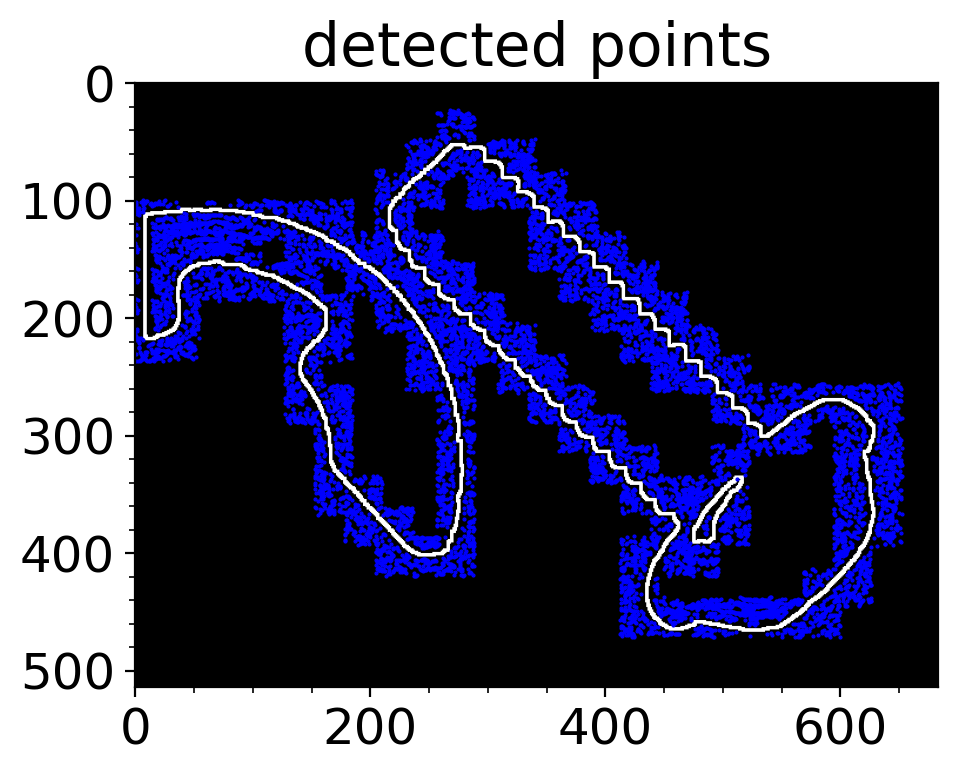

In [ ]:
vectors = edg_full - org # show the vectors also
plt.imshow(bw_img)
"""plt.quiver(org[:,1],org[:,0],vectors[:,1],vectors[:,0],angles='xy',
    scale_units='xy', scale=0.1, color = 'orange')"""
plt.scatter(edg_full[:,1],edg_full[:,0],c='blue',marker='.', s=1)
plt.title("detected points")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in double_scalars


3.083495616912842
<class 'list'>


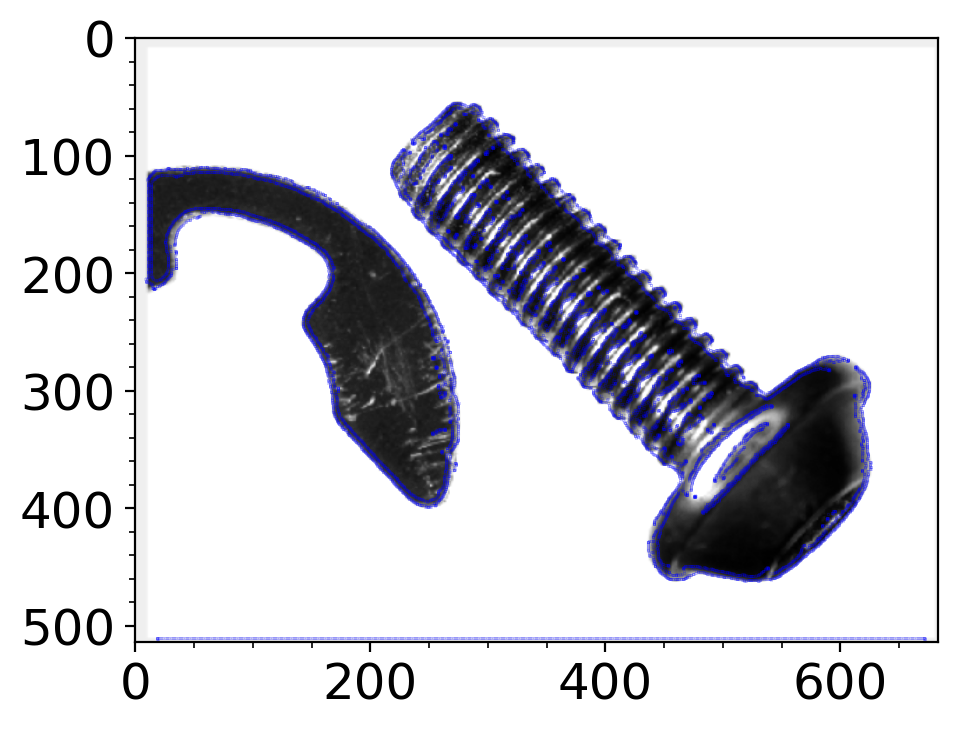

In [ ]:
g_N = 7

M00 = np.array([0, 0.0287, 0.0686, 0.0807, 0.0686, 0.0287, 0,
	0.0287, 0.0815, 0.0816, 0.0816, 0.0816, 0.0815, 0.0287,
	0.0686, 0.0816, 0.0816, 0.0816, 0.0816, 0.0816, 0.0686,
	0.0807, 0.0816, 0.0816, 0.0816, 0.0816, 0.0816, 0.0807,
	0.0686, 0.0816, 0.0816, 0.0816, 0.0816, 0.0816, 0.0686,
	0.0287, 0.0815, 0.0816, 0.0816, 0.0816, 0.0815, 0.0287,
	0, 0.0287, 0.0686, 0.0807, 0.0686, 0.0287, 0]).reshape((7, 7))


M11R = np.array([0, -0.015, -0.019, 0, 0.019, 0.015, 0,
	-0.0224, -0.0466, -0.0233, 0, 0.0233, 0.0466, 0.0224,
	-0.0573, -0.0466, -0.0233, 0, 0.0233, 0.0466, 0.0573,
	-0.069, -0.0466, -0.0233, 0, 0.0233, 0.0466, 0.069,
	-0.0573, -0.0466, -0.0233, 0, 0.0233, 0.0466, 0.0573,
	-0.0224, -0.0466, -0.0233, 0, 0.0233, 0.0466, 0.0224,
	0, -0.015, -0.019, 0, 0.019, 0.015, 0]).reshape((7, 7))


M11I = np.array([0, -0.0224, -0.0573, -0.069, -0.0573, -0.0224, 0,
	-0.015, -0.0466, -0.0466, -0.0466, -0.0466, -0.0466, -0.015,
	-0.019, -0.0233, -0.0233, -0.0233, -0.0233, -0.0233, -0.019,
	0, 0, 0, 0, 0, 0, 0,
	0.019, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.019,
	0.015, 0.0466, 0.0466, 0.0466, 0.0466, 0.0466, 0.015,
	0, 0.0224, 0.0573, 0.069, 0.0573, 0.0224, 0]).reshape((7, 7))


M20 = np.array([0, 0.0225, 0.0394, 0.0396, 0.0394, 0.0225, 0,
	0.0225, 0.0271, -0.0128, -0.0261, -0.0128, 0.0271, 0.0225,
	0.0394, -0.0128, -0.0528, -0.0661, -0.0528, -0.0128, 0.0394,
	0.0396, -0.0261, -0.0661, -0.0794, -0.0661, -0.0261, 0.0396,
	0.0394, -0.0128, -0.0528, -0.0661, -0.0528, -0.0128, 0.0394,
	0.0225, 0.0271, -0.0128, -0.0261, -0.0128, 0.0271, 0.0225,
	0, 0.0225, 0.0394, 0.0396, 0.0394, 0.0225, 0]).reshape((7, 7))


M31R = np.array([0, -0.0103, -0.0073, 0, 0.0073, 0.0103, 0,
	-0.0153, -0.0018, 0.0162, 0, -0.0162, 0.0018, 0.0153,
	-0.0223, 0.0324, 0.0333, 0, -0.0333, -0.0324, 0.0223,
	-0.0190, 0.0438, 0.0390, 0, -0.0390, -0.0438, 0.0190,
	-0.0223, 0.0324, 0.0333, 0, -0.0333, -0.0324, 0.0223,
	-0.0153, -0.0018, 0.0162, 0, -0.0162, 0.0018, 0.0153,
	0, -0.0103, -0.0073, 0, 0.0073, 0.0103, 0]).reshape(7, 7)


M31I = np.array([0, -0.0153, -0.0223, -0.019, -0.0223, -0.0153, 0,
	-0.0103, -0.0018, 0.0324, 0.0438, 0.0324, -0.0018, -0.0103,
	-0.0073, 0.0162, 0.0333, 0.039, 0.0333, 0.0162, -0.0073,
	0, 0, 0, 0, 0, 0, 0,
	0.0073, -0.0162, -0.0333, -0.039, -0.0333, -0.0162, 0.0073,
	0.0103, 0.0018, -0.0324, -0.0438, -0.0324, 0.0018, 0.0103,
	0, 0.0153, 0.0223, 0.0190, 0.0223, 0.0153, 0]).reshape(7, 7)


M40 = np.array([0, 0.013, 0.0056, -0.0018, 0.0056, 0.013, 0,
	0.0130, -0.0186, -0.0323, -0.0239, -0.0323, -0.0186, 0.0130,
	0.0056, -0.0323, 0.0125, 0.0406, 0.0125, -0.0323, 0.0056,
	-0.0018, -0.0239, 0.0406, 0.0751, 0.0406, -0.0239, -0.0018,
	0.0056, -0.0323, 0.0125, 0.0406, 0.0125, -0.0323, 0.0056,
	0.0130, -0.0186, -0.0323, -0.0239, -0.0323, -0.0186, 0.0130,
	0, 0.013, 0.0056, -0.0018, 0.0056, 0.013, 0]).reshape(7, 7)


def zernike_detection(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.imshow(img)
    blur_img = cv2.medianBlur(img, 13)
    c_img = cv2.adaptiveThreshold(blur_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 4)
    ZerImgM00 = cv2.filter2D(c_img, cv2.CV_64F, M00)
    ZerImgM11R = cv2.filter2D(c_img, cv2.CV_64F, M11R)
    ZerImgM11I = cv2.filter2D(c_img, cv2.CV_64F, M11I)
    ZerImgM20 = cv2.filter2D(c_img, cv2.CV_64F, M20)
    ZerImgM31R = cv2.filter2D(c_img, cv2.CV_64F, M31R)
    ZerImgM31I = cv2.filter2D(c_img, cv2.CV_64F, M31I)
    ZerImgM40 = cv2.filter2D(c_img, cv2.CV_64F, M40)

    point_temporary_x = []
    point_temporary_y = []
    scatter_arr = cv2.findNonZero(ZerImgM00).reshape(-1, 2)
    for idx in scatter_arr:
        j, i = idx
        theta_temporary = np.arctan2(ZerImgM31I[i][j], ZerImgM31R[i][j])
        rotated_z11 = np.sin(theta_temporary) * ZerImgM11I[i][j] + np.cos(theta_temporary) * ZerImgM11R[i][j]
        rotated_z31 = np.sin(theta_temporary) * ZerImgM31I[i][j] + np.cos(theta_temporary) * ZerImgM31R[i][j]
        l_method1 = np.sqrt((5 * ZerImgM40[i][j] + 3 * ZerImgM20[i][j]) / (8 * ZerImgM20[i][j]))

        l_method2 = np.sqrt((5 * rotated_z31 + rotated_z11)/(6 * rotated_z11))

        l = (l_method1 + l_method2)/2

        k = 3 * rotated_z11 / (2 * (1 - l_method2 ** 2)**1.5)

        # h = (ZerImgM00[i][j] - k * np.pi / 2 + k * np.arcsin(l_method2) + k * l_method2 * (1 - l_method2 ** 2) ** 0.5)
        # / np.pi
        k_value = 20.0
        l_value = 2**0.5 / g_N

        absl = np.abs(l_method2 - l_method1)

        if k >= k_value and absl <= l_value:
            y = i + g_N * l * np.sin(theta_temporary) / 2
            x = j + g_N * l * np.cos(theta_temporary) / 2
            point_temporary_x.append(x)
            point_temporary_y.append(y)
        else:
            continue

    return point_temporary_x, point_temporary_y


path = '/content/Nuts.png'
time1 = time.time()
point_temporary_x, point_temporary_y = zernike_detection(path)
time2 = time.time()
print(time2-time1)
print(type(point_temporary_x))

plt.scatter(point_temporary_x,point_temporary_y,c='blue',marker='.', s=.01)
plt.show()